In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
t2_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*t2.nii'))

In [3]:
mask_list = sorted(glob.glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    #temp_image_t1=nib.load(t1_list[img]).get_fdata()
    #temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    #temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    #temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    #temp_image_flair=nib.load(flair_list[img]).get_fdata()
    #temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    print(np.unique(temp_mask))
    
    
    #temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_image_t2=temp_image_t2[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    #val, counts = np.unique(temp_mask, return_counts=True)
    

    temp_mask= to_categorical(temp_mask, num_classes=4)
    temp_image_t2= to_categorical(temp_image_t2, num_classes=3)


        #np.save('/content/drive/MyDrive/np_images_t1/image_'+str(img)+'.npy', temp_image_t1)
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/T2_images/image_'+str(img)+'.npy', temp_image_t2)
        #np.save('/content/drive/MyDrive/np_images_t1ce/image_'+str(img)+'.npy', temp_image_t1ce)
        #np.save('/content/drive/MyDrive/np_images_flair/image_'+str(img)+'.npy', temp_image_flair)
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/masks/mask_'+str(img)+'.npy', temp_mask)
        
   

In [6]:
!pip install split-folders
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/data/'
output_folder = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 123 files [02:31,  1.23s/ files]


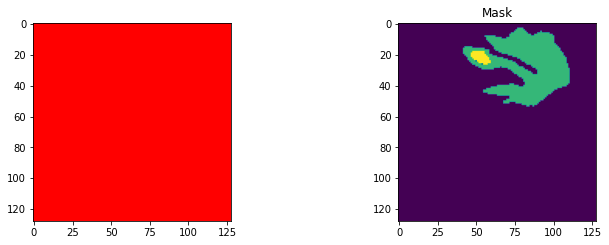

In [9]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/T2_images/"
train_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/validation/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
#plt.title('Image flair')
plt.subplot(222)
#plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
#plt.title('Image t1ce')
#plt.subplot(223)
#plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
#plt.title('Image t2')
#plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()